# Comparing NN-receiver performance against ZF/LS receiver performance on testset

In [1]:
from config import *
from OFDM_SDR_Functions_torch import *
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from models_local import *
from OFDM_SDR_Functions_torch import *
from torch.utils.tensorboard import SummaryWriter

device = torch.device("cuda:0" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))

# Display the selected device
print(device)

# Test tensor creation on the selected device
if device.type != "cpu":
    x = torch.ones(1, device=device)
    print(x)

device = "cpu" # Force CPU for now, trouble with converting complex tensors to mps


mps
tensor([1.], device='mps:0')


## Load the testset, model and weights

In [2]:

model = RXModel_2(Qm).to(device)

TTI_mask_RE = TTI_mask(S=S,F=F, Fp=Fp, Sp=Sp, FFT_offset=FFT_offset, plotTTI=False).to(device) # TTI mask
pilot_symbols = pilot_set(TTI_mask_RE, Pilot_Power).to(device) # pilot symbols

mapping_table_QPSK, de_mapping_table_QPSK = mapping_table(2) # mapping table QPSK (e.g. for pilot symbols)
mapping_table_Qm, de_mapping_table_Qm = mapping_table(Qm, plot=False) # mapping table for Qm

# load the testset
test_set = torch.load('data/ofdm_testset.pth')
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

# Load the model architecture and weights
checkpoint_path = 'data/rx_model.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Evaluate the model on the test set
test_losses_NN = []
test_BERs_NN = []
test_BERs_ZFLS = []
test_BERs_LMMSE = []



## Run the testset and measure BER with both receivers

In [3]:
TTI_mask_RE_3d = TTI_mask_RE.unsqueeze(-1).expand(S, FFT_size, Qm)


def labels4d23d(batch_size, labels):
    TTI_mask_indices = torch.where(TTI_mask_RE==1)
    TTI_3d = torch.zeros((batch_size, TTI_mask_RE.shape[0], TTI_mask_RE.shape[1], 4)).to(device)
    row_indices, col_indices = TTI_mask_indices
    row_indices.to(device)
    col_indices.to(device)
    TTI_3d[:, row_indices, col_indices, :] = labels.clone().detach().to(device)
    return TTI_3d

wrongs=[]
wrongs_ls=[]
sinrs = []
with torch.no_grad():
    for test_pdsch_iq, test_labels, sinr in test_loader:
        # NN receiver ###################################################
        test_outputs = model((test_pdsch_iq.to(device)))
        binary_predictions = test_outputs.squeeze()[TTI_mask_RE_3d==1]
        binary_predictions = torch.round(binary_predictions)
        test_labels = labels4d23d(1, test_labels)
        test_labels = test_labels.squeeze()[TTI_mask_RE_3d==1]

        # load a batch of data to the device
        test_pdsch_iq, test_labels = test_pdsch_iq.squeeze().to(device), test_labels.squeeze().to(device)
 
        error_count = torch.sum(binary_predictions != test_labels).float()  # Count of unequal bits

        new_wrongs = (binary_predictions.flatten() != test_labels.flatten()).float().tolist()
        wrongs.append(new_wrongs)

        
        error_rate = error_count / len(test_labels.flatten())  # Error rate calculation
        BER_NN = torch.round(error_rate * 1000) / 1000  # Round to 3 decimal places
        test_BERs_NN.append(BER_NN.item())

        # ZF-LS receiver ####################################################

        test_pdsch_iq_w = test_pdsch_iq
        
        # calculate channel estimate

        H_estim = channelEstimate_LS(TTI_mask_RE, pilot_symbols, F, FFT_offset, Sp, test_pdsch_iq_w, plotEst=False)

        # remove FFT offsets
        test_pdsch_iq_w = remove_fft_Offests(test_pdsch_iq_w, F, FFT_offset)
        
        # equalize the received signal
        equalized_H_estim = equalize_ZF(test_pdsch_iq_w, H_estim, F, S)
        
        # get the payload symbols 
        QAM_est = get_payload_symbols(TTI_mask_RE, equalized_H_estim, FFT_offset, F, plotQAM=False)

        # demap the symbols
        PS_est, hardDecision = Demapping(QAM_est, de_mapping_table_Qm)

        # convert to bits
        bits_est = torch.tensor(PS(PS_est).flatten().cpu(), dtype=torch.int8)

        # Calculate Bit Error Rate (BER) for the ZF-LS receiver
        test_labels = torch.tensor(test_labels.flatten().cpu(), dtype=torch.int8)
        
        new_wrongs_ls = (bits_est != test_labels).float().tolist()
        wrongs_ls.append(new_wrongs_ls)
        
        error_count = torch.sum(bits_est != test_labels).float()  # Count of unequal bits
        error_rate = error_count / bits_est.numel()  # Error rate calculation
        BER_ZFLS = torch.round(error_rate * 1000) / 1000  # Round to 3 decimal places

        # LMMSE receiver ####################################################

        #equalized_H_estim = equalize_ZF(test_pdsch_iq_w, H_estim, F, S)
        equalized_H_estim = equalize_LMMSE(test_pdsch_iq_w, H_estim, sinr, F, S)

        # get the payload symbols 
        QAM_est = get_payload_symbols(TTI_mask_RE, equalized_H_estim, FFT_offset, F, plotQAM=False)

        # demap the symbols
        PS_est, hardDecision = Demapping(QAM_est, de_mapping_table_Qm)

        # convert to bits
        bits_est = torch.tensor(PS(PS_est).flatten().cpu(), dtype=torch.int8)

        # Calculate Bit Error Rate (BER) for the ZF-LS receiver
        test_labels = torch.tensor(test_labels.flatten().cpu(), dtype=torch.int8)
        
        new_wrongs_ls = (bits_est != test_labels).float().tolist()
        wrongs_ls.append(new_wrongs_ls)
        
        error_count = torch.sum(bits_est != test_labels).float()  # Count of unequal bits
        error_rate = error_count / bits_est.numel()  # Error rate calculation
        BER_LMMSE = torch.round(error_rate * 1000) / 1000  # Round to 3 decimal places

        test_BERs_ZFLS.append(BER_ZFLS.item())
        test_BERs_LMMSE.append(BER_LMMSE.item())

        sinrs.append(sinr.numpy())



/var/folders/8d/3ktk5sxn64316lz6dtjghw640000gn/T/ipykernel_68440/1479345612.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bits_est = torch.tensor(PS(PS_est).flatten().cpu(), dtype=torch.int8)
/var/folders/8d/3ktk5sxn64316lz6dtjghw640000gn/T/ipykernel_68440/1479345612.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels.flatten().cpu(), dtype=torch.int8)
/var/folders/8d/3ktk5sxn64316lz6dtjghw640000gn/T/ipykernel_68440/1479345612.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bits_est = to

In [23]:
test_data = test_pdsch_iq.unsqueeze(0)
print(test_data.shape)

writer = SummaryWriter("torchlogs/")
writer.add_graph(model, test_data)
writer.close()

torch.Size([1, 14, 128])


## observe if there are time domain problems, either in the NN, or in the LS receiver

Text(0, 0.5, 'cumulative errors')

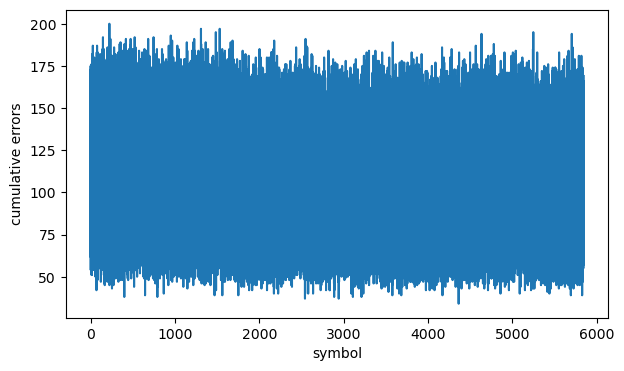

In [ ]:
# NN receiver
fig = plt.figure(figsize=(7,4))
plt.plot(np.sum(wrongs, axis=0))
plt.xlabel('symbol')
plt.ylabel('cumulative errors')

Text(0, 0.5, 'cumulative errors')

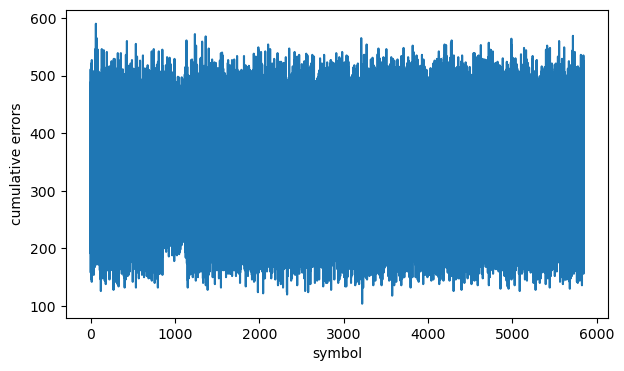

In [ ]:
#LZ/ZF receiver
fig = plt.figure(figsize=(7,4))
plt.plot(np.sum(wrongs_ls, axis=0))
plt.xlabel('symbol')
plt.ylabel('cumulative errors')

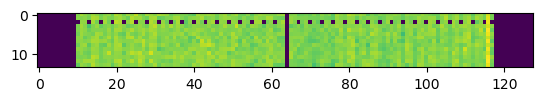

In [ ]:
# Create a zero tensor for the overall F subcarriers * S symbols
TTI_t = np.zeros(TTI_mask_RE.shape)
wrongs = np.array(wrongs_ls).astype(int)
wrongs=wrongs.sum(axis=0)
wrongs=wrongs.reshape([1462,4]).sum(axis=1)

# Allocate the payload and pilot
TTI_t[TTI_mask_RE==1] = wrongs
plt.imshow(TTI_t)

## Calculate the mean BER, illustrate BER distribution

In [ ]:
# Calculate average test loss and BER
average_test_BER_NN = sum(test_BERs_NN) / len(test_BERs_NN)
average_test_BER_ZFLS = sum(test_BERs_ZFLS) / len(test_BERs_ZFLS)
average_test_BER_LMMSE = sum(test_BERs_LMMSE) / len(test_BERs_LMMSE)

# Print or log average test loss and BER for both the NN and ZF-LS receiver
print('Average test BER NN: {:.4f}'.format(average_test_BER_NN))
print('Average test BER ZF-LS: {:.4f}'.format(average_test_BER_ZFLS))
print('Average test BER LMMSE: {:.4f}'.format(average_test_BER_LMMSE))

Average test BER NN: 0.0547
Average test BER ZF-LS: 0.0831
Average test BER LMMSE: 0.0875


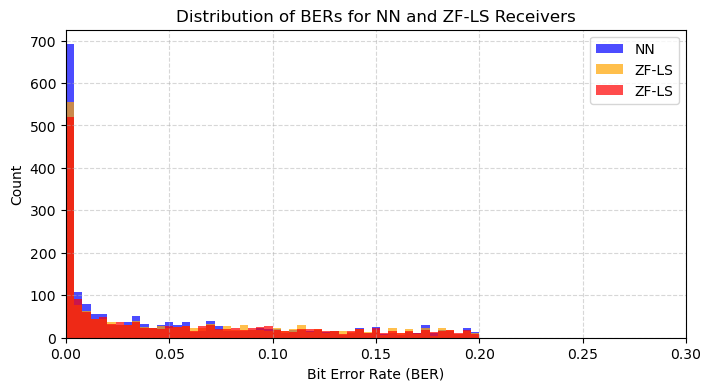

In [ ]:
bins = np.linspace(0, 0.2, 51)

# Plotting with logarithmic scale for y-axis
plt.figure(figsize=(8, 4))
plt.hist(test_BERs_NN, bins=bins, alpha=0.7, color='blue', label='NN')
plt.hist(test_BERs_ZFLS, bins=bins, alpha=0.7, color='orange', label='ZF-LS')
plt.hist(test_BERs_LMMSE, bins=bins, alpha=0.7, color='red', label='ZF-LS')
plt.xlabel('Bit Error Rate (BER)')
plt.ylabel('Count')
plt.title('Distribution of BERs for NN and ZF-LS Receivers')
plt.legend()
plt.xlim(0, 0.3)
#plt.yscale('log')  # Setting y-axis to logarithmic scale
plt.grid(True, linestyle='--', alpha=0.5)
if save_plots:
    plt.savefig('pics/BER_distribution_testset_log_scale.png', bbox_inches='tight')
plt.show()

      BER_NN  BER_LSZF  BER_LMMSE  SINR
0      0.075     0.109      0.116    10
1      0.092     0.131      0.139     9
2      0.170     0.205      0.215     7
3      0.081     0.114      0.125    10
4      0.009     0.015      0.016    20
...      ...       ...        ...   ...
1995   0.035     0.053      0.061    12
1996   0.105     0.166      0.177     9
1997   0.008     0.012      0.015    15
1998   0.016     0.031      0.037    14
1999   0.072     0.123      0.132    10

[2000 rows x 4 columns]


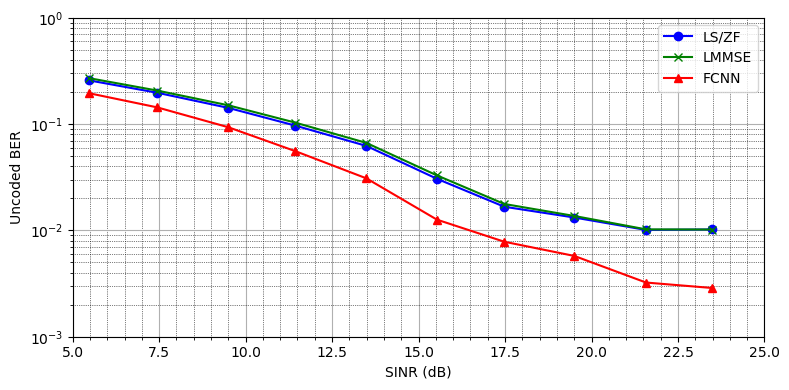

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import re


df = pd.DataFrame({
    'BER_NN': np.squeeze(test_BERs_NN),
    'BER_LSZF': np.squeeze(test_BERs_ZFLS),
    'BER_LMMSE': np.squeeze(test_BERs_LMMSE),
    'SINR': np.squeeze(sinrs)
})

print(df)

df['SINR_binned'] = pd.cut(df['SINR'], bins=range(-10, 40, 2), labels=range(-9, 39, 2))
df_grouped = df.groupby('SINR_binned', observed=False).mean()

plt.figure(figsize=(8, 4))
plt.xlabel('SINR (dB)')
plt.ylabel('Uncoded BER')
plt.plot(df_grouped['SINR'], df_grouped['BER_LSZF'], '-o', color='blue', label='LS/ZF', markersize=6)
plt.plot(df_grouped['SINR'], df_grouped['BER_LMMSE'], '-x', color='green', label='LMMSE', markersize=6)
plt.plot(df_grouped['SINR'], df_grouped['BER_NN'], '-^', color='red', label = 'FCNN', markersize=6)
plt.legend()
#plt.title(f'Uncoded Bit Error Rate, static\n BER LS/ZF mean={BER_LSZF_mean}, BER NN mean={BER_NN_mean}')
plt.xlim(5, 25)
plt.yscale('log')
plt.ylim(1e-3, 1)   
plt.grid()
plt.minorticks_on()
plt.tight_layout()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
if save_plots:
    plt.savefig(f'pics/SINR2BER_test.png', bbox_inches='tight')
plt.show()